In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import matplotlib.ticker as ticker

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Mounted at /content/gdrive


# Carregar arquivos e montar série histórica a partir de epws

In [4]:
os.chdir("/content/gdrive/My Drive/Pesquisa/1 Artigos em desenvolvimento/2025_11_swc_heatwave_detection_vs_NBR15575/1 Desenvolvimento/data")
filelist = os.listdir()

In [5]:
all_MYs = pd.DataFrame()
for filename in filelist:
    if filename.endswith(".epw"):
        df_temp = pd.read_csv(f"{filename}", sep=',', skiprows=8, header=None)
        all_MYs = pd.concat([all_MYs,df_temp])
        continue
    else:
        continue

In [6]:
all_MYs.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1962,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9?9...,19.0,18.0,94,90082,...,101,0,19999999,54,0.164,0,88,0.17,0.0,0.0
1,1962,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9?9...,18.7,18.0,96,89982,...,103,0,19999999,54,0.164,0,88,0.17,0.0,0.0
2,1962,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9?9...,18.7,18.0,96,89991,...,88,0,19999999,54,0.164,0,88,0.17,0.0,0.0
3,1962,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9?9...,18.8,18.0,95,90030,...,118,0,19999999,54,0.164,0,88,0.17,0.0,0.0
4,1962,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9?9...,18.8,17.0,89,89986,...,87,0,19999999,48,0.164,0,88,0.17,0.0,0.0


In [7]:
# Criar a nova coluna com o timeset
all_MYs['timeset'] = pd.to_datetime(all_MYs.iloc[:, [0, 1, 2, 3, 4]].rename(columns={0: 'year', 1: 'month', 2: 'day', 3: 'hour', 4: 'minute'}))

In [8]:
all_MYs = all_MYs.sort_values(by='timeset').reset_index(drop=True)

# Cálculo das normais climatológicas

In [9]:
# Filtrar o período de 1991 a 2020
df_filtered = all_MYs[(all_MYs['timeset'] >= '1991-01-01') & (all_MYs['timeset'] <= '2020-12-31')]

In [10]:
# Calcular a temperatura máxima diária
daily_max = df_filtered.groupby(df_filtered['timeset'].dt.date)[6].max().reset_index()

In [11]:
# Calcular a média mensal das temperaturas máximas diárias
monthly_mean_max = daily_max.groupby(pd.to_datetime(daily_max['timeset']).dt.to_period('M'))[6].mean().reset_index()

In [12]:
# Criar uma coluna para o número do mês
monthly_mean_max['month'] = monthly_mean_max['timeset'].dt.month

In [13]:
monthly_mean_max

,timeset,6,month
0,1991-01,27.496774,1
1,1991-02,28.356071,2
2,1991-03,27.190323,3
3,1991-04,28.208000,4
4,1991-05,26.812903,5
...,...,...,...
355,2020-08,28.193548,8
356,2020-09,30.996667,9
357,2020-10,30.664516,10
358,2020-11,28.283333,11


In [14]:
# Calcular a média das temperaturas máximas para cada mês (independente do ano)
mean_over_period = monthly_mean_max.groupby('month')[6].mean().reset_index()

In [15]:
mean_over_period

,month,6
0,1,27.820903
1,2,28.081420
2,3,27.848720
3,4,27.834100
4,5,26.973871
5,6,26.268389
6,7,26.449258
7,8,28.168419
8,9,29.820233
9,10,29.712538


# Detecção de onda de calor

In [16]:
# Calcular a temperatura máxima diária
daily_max = all_MYs.groupby(all_MYs['timeset'].dt.date)[6].max().reset_index()
daily_max['timeset'] = pd.to_datetime(daily_max['timeset'])

In [17]:
daily_max

,timeset,6
0,1961-01-01,25.50
1,1961-01-02,29.48
2,1961-01-03,27.88
3,1961-01-04,25.00
4,1961-01-05,26.80
...,...,...
22641,2023-12-28,30.00
22642,2023-12-29,31.00
22643,2023-12-30,31.00
22644,2023-12-31,27.00


In [18]:
# Associar a normal mensal à data correspondente
monthly_mean_dict = mean_over_period.set_index('month')[6].to_dict()
daily_max['month'] = daily_max['timeset'].dt.month
daily_max['climatological_normal'] = daily_max['month'].map(monthly_mean_dict)

In [19]:
daily_max

,timeset,6,month,climatological_normal
0,1961-01-01,25.50,1,27.820903
1,1961-01-02,29.48,1,27.820903
2,1961-01-03,27.88,1,27.820903
3,1961-01-04,25.00,1,27.820903
4,1961-01-05,26.80,1,27.820903
...,...,...,...,...
22641,2023-12-28,30.00,12,27.592581
22642,2023-12-29,31.00,12,27.592581
22643,2023-12-30,31.00,12,27.592581
22644,2023-12-31,27.00,12,27.592581


In [20]:
# Definir o limite de onda de calor (normal + 5°C)
daily_max['heat_wave_threshold'] = daily_max['climatological_normal'] + 5

In [21]:
daily_max

,timeset,6,month,climatological_normal,heat_wave_threshold
0,1961-01-01,25.50,1,27.820903,32.820903
1,1961-01-02,29.48,1,27.820903,32.820903
2,1961-01-03,27.88,1,27.820903,32.820903
3,1961-01-04,25.00,1,27.820903,32.820903
4,1961-01-05,26.80,1,27.820903,32.820903
...,...,...,...,...,...
22641,2023-12-28,30.00,12,27.592581,32.592581
22642,2023-12-29,31.00,12,27.592581,32.592581
22643,2023-12-30,31.00,12,27.592581,32.592581
22644,2023-12-31,27.00,12,27.592581,32.592581


In [22]:
# Verificar se a temperatura máxima excede o limite
daily_max['above_threshold'] = daily_max[6] > daily_max['heat_wave_threshold']

In [23]:
daily_max.to_csv('daily_max.csv', index=False)

In [24]:
# Resultado intermediário
print(daily_max[daily_max['above_threshold']][['timeset', 6, 'heat_wave_threshold']])

         timeset      6  heat_wave_threshold
298   1961-10-26  35.17            34.712538
299   1961-10-27  36.30            34.712538
325   1961-11-22  33.20            32.735422
326   1961-11-23  33.70            32.735422
328   1961-11-25  32.80            32.735422
...          ...    ...                  ...
22598 2023-11-15  35.00            32.735422
22599 2023-11-16  35.00            32.735422
22600 2023-11-17  33.00            32.735422
22622 2023-12-09  33.50            32.592581
22623 2023-12-10  33.00            32.592581

[141 rows x 3 columns]


In [25]:
# Identificar sequências de dias consecutivos acima do limiar
daily_max['event_id'] = (daily_max['above_threshold'] != daily_max['above_threshold'].shift()).cumsum()

In [26]:
# Contar o número de dias consecutivos para cada sequência
event_counts = daily_max.groupby('event_id')['above_threshold'].sum()
valid_events = event_counts[event_counts >= 2].index

In [27]:
valid_events

Index([  2,   4,  18,  20,  24,  36,  46,  48,  52,  60,  64,  74,  86,  88,
       102, 104, 112, 118, 122, 126, 130, 134, 136, 140, 144, 146, 154, 156,
       158, 162, 164],
      dtype='int64', name='event_id')

In [28]:
# Classificar os eventos com base na duração
def classify_heat_wave(event_id):
    if event_id not in valid_events:
        return ''
    duration = event_counts[event_id]
    if 2 <= duration <= 3:
        return 'Yellow'
    elif 3 < duration <= 5:
        return 'Orange'
    elif duration > 5:
        return 'Red'
    return ''

In [29]:
# Atribuir o nível de alerta conforme a classificação
daily_max['heat_wave_alert'] = daily_max['event_id'].map(classify_heat_wave)

In [30]:
daily_max

,timeset,6,month,climatological_normal,heat_wave_threshold,above_threshold,event_id,heat_wave_alert
0,1961-01-01,25.50,1,27.820903,32.820903,False,1,
1,1961-01-02,29.48,1,27.820903,32.820903,False,1,
2,1961-01-03,27.88,1,27.820903,32.820903,False,1,
3,1961-01-04,25.00,1,27.820903,32.820903,False,1,
4,1961-01-05,26.80,1,27.820903,32.820903,False,1,
...,...,...,...,...,...,...,...,...
22641,2023-12-28,30.00,12,27.592581,32.592581,False,165,
22642,2023-12-29,31.00,12,27.592581,32.592581,False,165,
22643,2023-12-30,31.00,12,27.592581,32.592581,False,165,
22644,2023-12-31,27.00,12,27.592581,32.592581,False,165,


In [31]:
daily_max.to_csv('daily_max.csv', index=False)

# Integração ao dataframe completo

In [32]:
# Fazer o merge com base na data (ignorando a hora)
all_MYs['date'] = all_MYs['timeset'].dt.date
daily_max['date'] = daily_max['timeset'].dt.date

In [33]:
# Fazer o merge (left join para manter todos os dados de All_MYs)
all_MYs = all_MYs.merge(
    daily_max[['date', 'heat_wave_alert']],
    on='date',
    how='left'
)

In [34]:
# Remover a coluna auxiliar 'date' após o merge
all_MYs.drop(columns=['date'], inplace=True)

In [35]:
# Exibir o resultado para checar
print(all_MYs[['timeset', 6, 'heat_wave_alert']].head(20))

               timeset     6 heat_wave_alert
0  1961-01-01 01:00:00  19.1                
1  1961-01-01 02:00:00  18.9                
2  1961-01-01 03:00:00  18.7                
3  1961-01-01 04:00:00  18.5                
4  1961-01-01 05:00:00  18.5                
5  1961-01-01 06:00:00  18.4                
6  1961-01-01 07:00:00  18.1                
7  1961-01-01 08:00:00  18.2                
8  1961-01-01 09:00:00  19.6                
9  1961-01-01 10:00:00  22.5                
10 1961-01-01 11:00:00  23.5                
11 1961-01-01 12:00:00  24.5                
12 1961-01-01 13:00:00  25.5                
13 1961-01-01 14:00:00  24.8                
14 1961-01-01 15:00:00  20.0                
15 1961-01-01 16:00:00  23.1                
16 1961-01-01 17:00:00  22.0                
17 1961-01-01 18:00:00  24.8                
18 1961-01-01 19:00:00  24.5                
19 1961-01-01 20:00:00  23.0                


In [36]:
# Exportar para csv
all_MYs.to_csv('all_MYs_heatwaves_inmet.csv', index=False)

# Gráficos

In [ ]:
sns.set(style="whitegrid")  # Estilo limpo com linhas suaves

In [ ]:
# Extrair o ano da coluna 'timeset' para contar os eventos por ano
daily_max['year'] = daily_max['timeset'].dt.year

# Criar uma sequência contínua de anos
all_years = np.arange(daily_max['year'].min(), daily_max['year'].max() + 1)

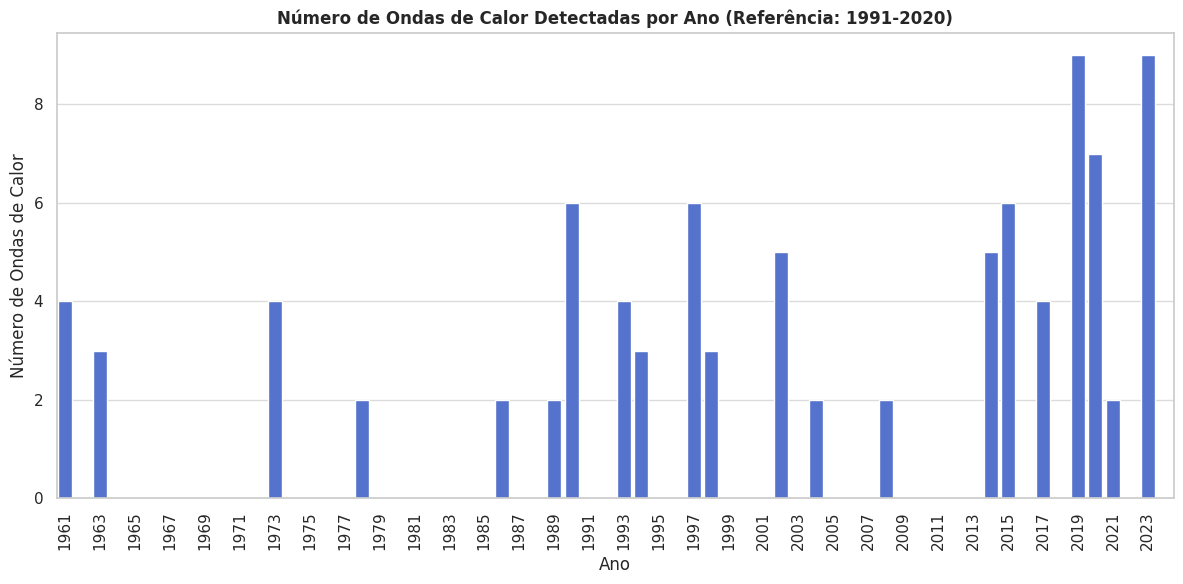

In [ ]:
# Gráfico 1: Número de ondas de calor detectadas por ano
heat_wave_count_per_year = daily_max[daily_max['heat_wave_alert'] != ''].groupby('year').size()
heat_wave_count_per_year = heat_wave_count_per_year.reindex(all_years, fill_value=0)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=heat_wave_count_per_year.index, y=heat_wave_count_per_year.values, color='royalblue')
ax.set_title('Número de Ondas de Calor Detectadas por Ano (Referência: 1991-2020)', fontsize=12, weight='bold')
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Número de Ondas de Calor', fontsize=12)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(36))
plt.tight_layout()  # Ajusta os espaçamentos automaticamente
plt.grid(axis='y', linestyle='-', alpha=0.7)

plt.show()

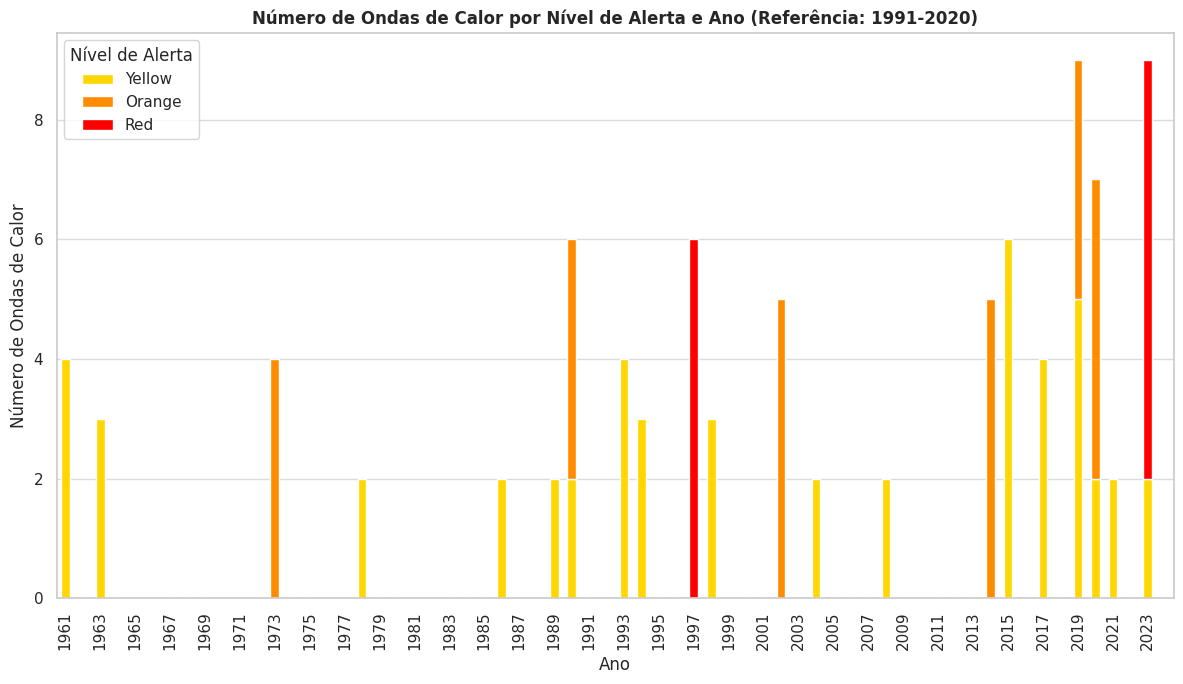

In [ ]:
# Gráfico 2: Número de ondas de calor por nível de alerta (Yellow, Orange, Red)
heat_wave_alert_per_year = daily_max[daily_max['heat_wave_alert'] != ''].groupby(['year', 'heat_wave_alert']).size().unstack(fill_value=0)
heat_wave_alert_per_year = heat_wave_alert_per_year.reindex(all_years, fill_value=0)

heat_wave_alert_per_year = heat_wave_alert_per_year[['Yellow', 'Orange', 'Red']]

ax = heat_wave_alert_per_year.plot(kind='bar', stacked=True, figsize=(12, 7),
                                   color={'Yellow': 'gold', 'Orange': 'darkorange', 'Red': 'red'})
plt.title('Número de Ondas de Calor por Nível de Alerta e Ano (Referência: 1991-2020)', fontsize=12, weight='bold')
plt.xlabel('Ano')
plt.ylabel('Número de Ondas de Calor')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(36))
plt.tight_layout()
plt.legend(title='Nível de Alerta')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.grid(axis='x', linestyle='', alpha=0)

plt.show()

# Heat index

In [ ]:
# Coeficientes para o cálculo do Heat Index (ajustado para °C)
c1 = -8.78469475556
c2 = 1.61139411
c3 = 2.33854883889
c4 = -0.14611605
c5 = -0.012308094
c6 = -0.0164248277778
c7 = 0.002211732
c8 = 0.00072546
c9 = -0.000003582

In [ ]:
# Garantir que os valores de temperatura (coluna 6) e umidade (coluna 8) estão em formato numérico
all_MYs[6] = pd.to_numeric(all_MYs[6], errors='coerce')
all_MYs[8] = pd.to_numeric(all_MYs[8], errors='coerce')

In [ ]:
# Calcular o Heat Index
T = all_MYs[6]
RH = all_MYs[8]

all_MYs['heat_index'] = (
    c1 + (c2 * T) + (c3 * RH) + (c4 * T * RH) +
    (c5 * T**2) + (c6 * RH**2) + (c7 * T**2 * RH) +
    (c8 * T * RH**2) + (c9 * T**2 * RH**2)
)

In [ ]:
# Exibir o resultado calculado
print(all_MYs[['timeset', 6, 8, 'heat_index', 'heat_wave_alert']].head(10))

              timeset     6   8  heat_index heat_wave_alert
0 1961-01-01 01:00:00  19.1  93   16.962687                
1 1961-01-01 02:00:00  18.9  95   16.101597                
2 1961-01-01 03:00:00  18.7  96   15.596005                
3 1961-01-01 04:00:00  18.5  97   15.075482                
4 1961-01-01 05:00:00  18.5  97   15.075482                
5 1961-01-01 06:00:00  18.4  92   17.086318                
6 1961-01-01 07:00:00  18.1  93   16.624218                
7 1961-01-01 08:00:00  18.2  93   16.643449                
8 1961-01-01 09:00:00  19.6  90   18.247172                
9 1961-01-01 10:00:00  22.5  81   22.494779                


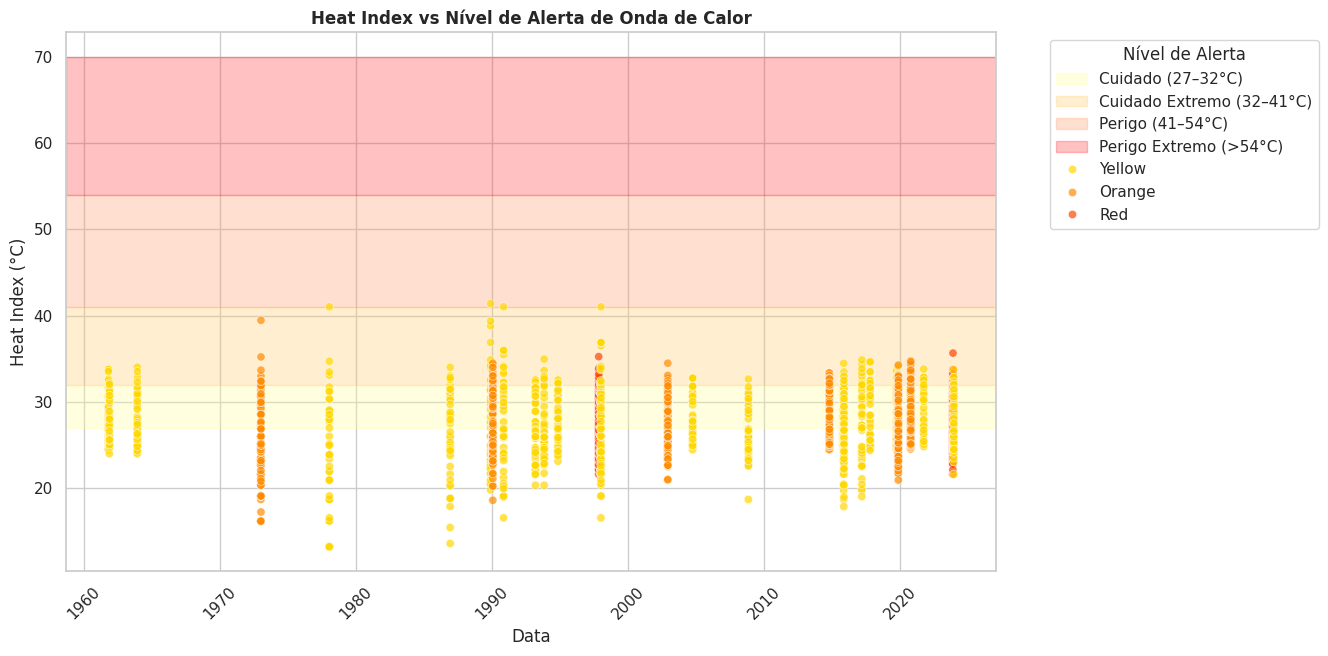

In [ ]:
# Filtrar apenas os dados com alerta válido
df_plot = all_MYs[all_MYs['heat_wave_alert'].notna() & (all_MYs['heat_wave_alert'] != '')]

plt.figure(figsize=(12, 7))

# Adicionar faixas de perigo (NOAA)
plt.axhspan(27, 32, color='#FFFF99', alpha=0.3, label='Cuidado (27–32°C)')
plt.axhspan(32, 41, color='#FFCC66', alpha=0.3, label='Cuidado Extremo (32–41°C)')
plt.axhspan(41, 54, color='#FF9966', alpha=0.3, label='Perigo (41–54°C)')
plt.axhspan(54, 70, color='#FF3333', alpha=0.3, label='Perigo Extremo (>54°C)')

# Criar o gráfico de dispersão
sns.scatterplot(
    data=df_plot,
    x='timeset',
    y='heat_index',
    hue='heat_wave_alert',
    palette={'Yellow': '#FFD700', 'Orange': '#FF8C00', 'Red': '#FF4500'},
    alpha=0.7
)


# Ajustar detalhes do gráfico
plt.title('Heat Index vs Nível de Alerta de Onda de Calor', fontsize=12, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Nível de Alerta', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<ipython-input-46-7684f0f78c6d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


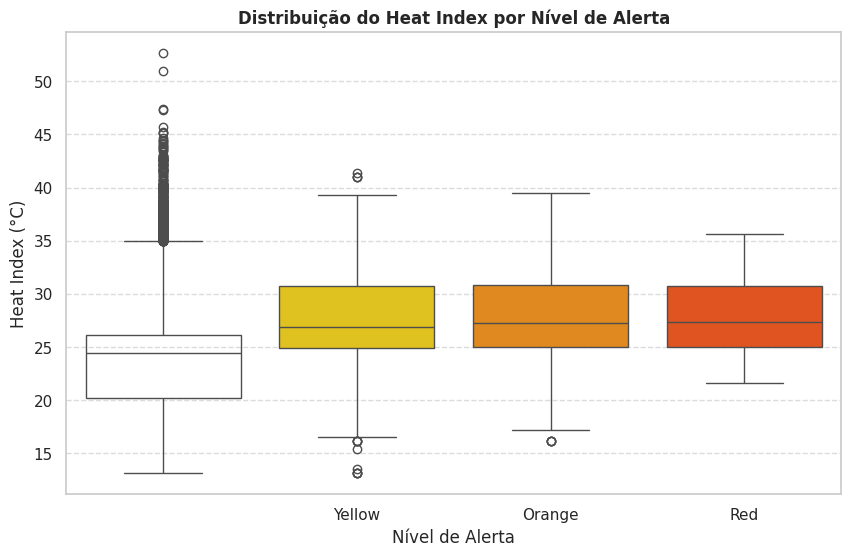

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=all_MYs[all_MYs['heat_wave_alert'].notna()],
    x='heat_wave_alert',
    y='heat_index',
    palette={'Yellow': '#FFD700', 'Orange': '#FF8C00', 'Red': '#FF4500'}
)

# Ajustar detalhes do gráfico
plt.title('Distribuição do Heat Index por Nível de Alerta', fontsize=12, weight='bold')
plt.xlabel('Nível de Alerta', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

<ipython-input-47-b3afc0f5058d>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean_hi = all_MYs.set_index('timeset')['heat_index'].resample('M').mean()


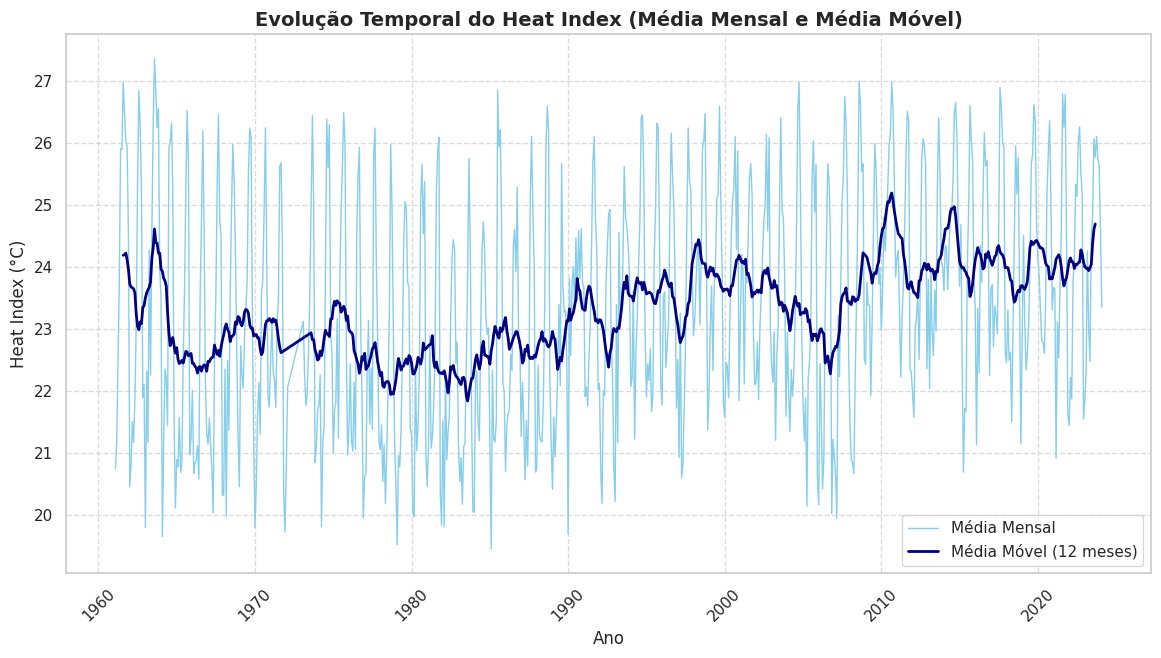

In [ ]:
plt.figure(figsize=(14, 7))

# Calcular a média mensal do Heat Index
monthly_mean_hi = all_MYs.set_index('timeset')['heat_index'].resample('M').mean()

# Aplicar uma média móvel para suavizar as variações (janela de 12 meses)
rolling_mean_hi = monthly_mean_hi.rolling(window=12, center=True).mean()

# Plotar a média mensal
sns.lineplot(data=monthly_mean_hi, label='Média Mensal', color='skyblue', linewidth=1)
sns.lineplot(data=rolling_mean_hi, label='Média Móvel (12 meses)', color='navy', linewidth=2)

# Ajustar detalhes do gráfico
plt.title('Evolução Temporal do Heat Index (Média Mensal e Média Móvel)', fontsize=14, weight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.show()

<ipython-input-48-e651b1762e2d>:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


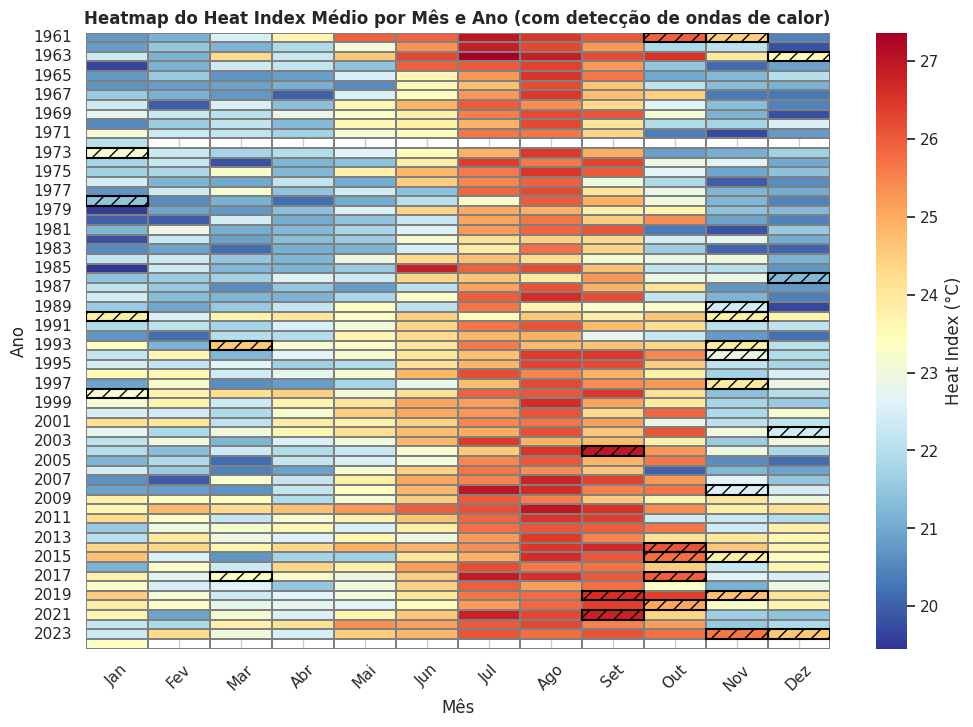

In [ ]:
# Criar uma nova coluna para o ano e o mês
all_MYs['year'] = all_MYs['timeset'].dt.year
all_MYs['month'] = all_MYs['timeset'].dt.month

# Calcular a média mensal do Heat Index por ano
heatmap_data = all_MYs.pivot_table(
    index='year',
    columns='month',
    values='heat_index',
    aggfunc='mean'
)

# Ajustar a máscara para considerar apenas alertas válidos (Yellow, Orange, Red)
valid_alerts = ['Yellow', 'Orange', 'Red']
highlight = all_MYs.pivot_table(
    index='year',
    columns='month',
    values='heat_wave_alert',
    aggfunc=lambda x: any(i in valid_alerts for i in x.dropna())
).fillna(False)

# Criar o heatmap com contraste aprimorado
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap='RdYlBu_r',  # Maior contraste
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={'label': 'Heat Index (°C)'}
)

# Adicionar hachura diagonal para meses com onda de calor detectada
for y in range(highlight.shape[0]):
    for x in range(highlight.shape[1]):
        if highlight.iloc[y, x]:
            plt.gca().add_patch(plt.Rectangle(
                (x, y), 1, 1, fill=False,
                edgecolor='black', lw=1.5, hatch='//'
            ))

# Ajustar detalhes do gráfico
plt.title('Heatmap do Heat Index Médio por Mês e Ano (com detecção de ondas de calor)', fontsize=12, weight='bold')
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Ano', fontsize=12)
plt.xticks(ticks=np.arange(12) + 0.5, labels=[
    'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'
], rotation=45)

plt.show()


Dias com alerta: 5227
Dias sem alerta mas com HI elevado: 4956


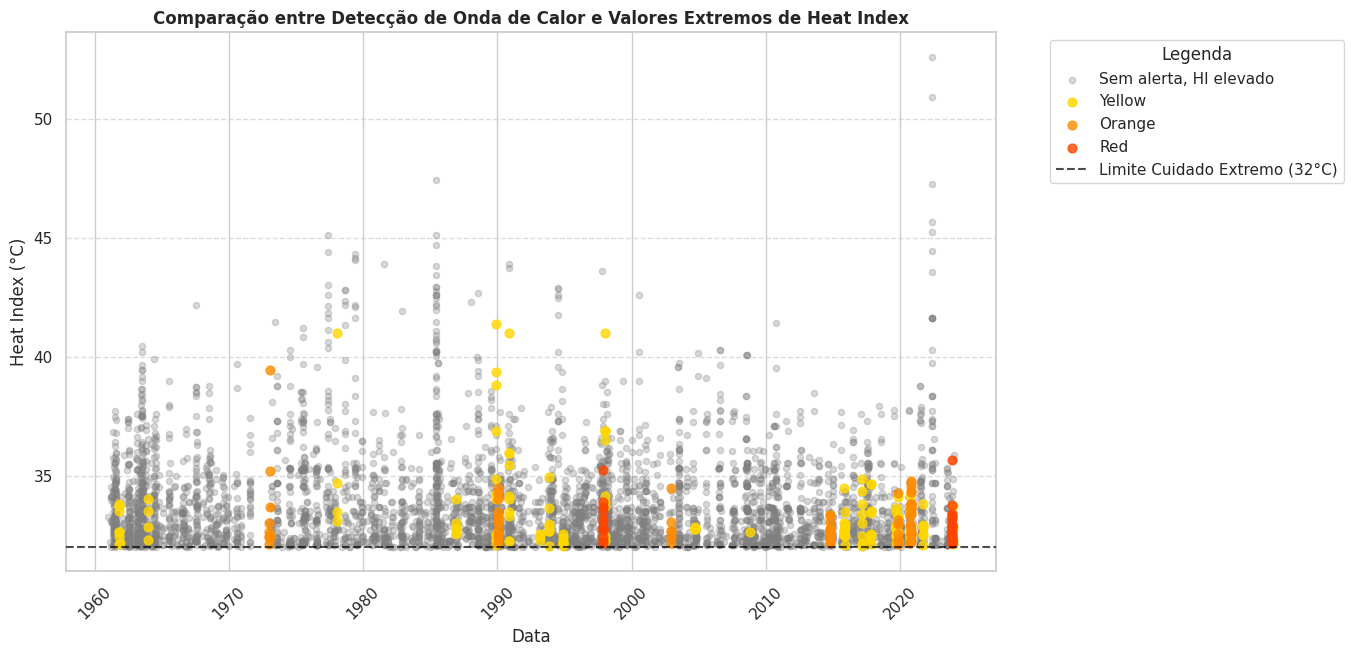

In [ ]:
plt.figure(figsize=(12, 7))

# Separar dados com e sem alerta de onda de calor (somente com HI > 32°C)
df_alert = all_MYs[(all_MYs['heat_wave_alert'].notna()) & (all_MYs['heat_index'] > 32)]
df_no_alert = all_MYs[(all_MYs['heat_wave_alert'] == '') & (all_MYs['heat_index'] > 32)]

# 🔎 Verificar o tamanho dos dataframes
print(f'Dias com alerta: {len(df_alert)}')
print(f'Dias sem alerta mas com HI elevado: {len(df_no_alert)}')

# Plotar os dias sem alerta (primeiro plano, menor transparência e tamanho menor)
plt.scatter(
    df_no_alert['timeset'],
    df_no_alert['heat_index'],
    color='gray',
    alpha=0.3,  # Maior transparência para não cobrir os pontos com alerta
    s=20,
    label='Sem alerta, HI elevado',
    zorder=1
)

# Plotar os dias com alerta (segundo plano, cores por nível de alerta)
plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'timeset'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'heat_index'],
    color='#FFD700',
    label='Yellow',
    s=40,
    alpha=0.8,
    zorder=2
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'timeset'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'heat_index'],
    color='#FF8C00',
    label='Orange',
    s=40,
    alpha=0.8,
    zorder=3
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'timeset'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'heat_index'],
    color='#FF4500',
    label='Red',
    s=40,
    alpha=0.8,
    zorder=4
)

# Adicionar linha de referência para Heat Index > 32°C (limite de "cuidado extremo" pela NOAA)
plt.axhline(32, color='black', linestyle='--', alpha=0.7, label='Limite Cuidado Extremo (32°C)', zorder=5)

# Ajustar detalhes do gráfico
plt.title('Comparação entre Detecção de Onda de Calor e Valores Extremos de Heat Index', fontsize=12, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Horas com alerta: 543456
Horas sem alerta: 541296


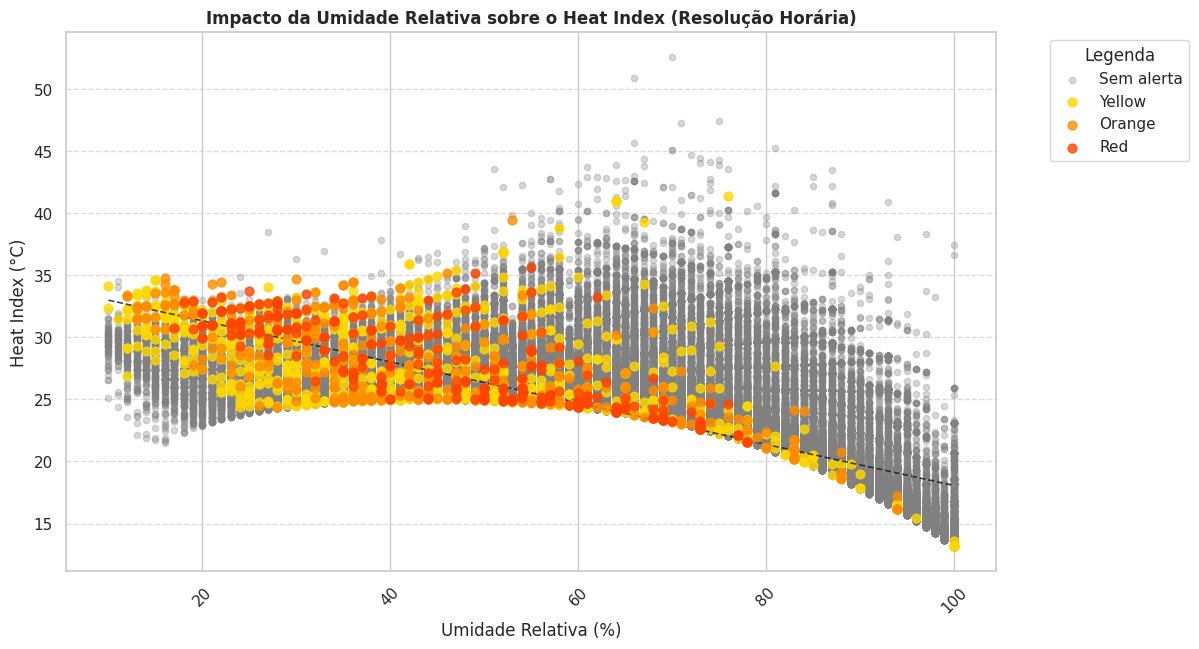

In [ ]:
plt.figure(figsize=(12, 7))

# Separar HORAS com e sem alerta de onda de calor
df_alert = all_MYs[all_MYs['heat_wave_alert'].notna()]
df_no_alert = all_MYs[all_MYs['heat_wave_alert'] == '']

# 🔎 Verificar o tamanho dos dataframes (em horas)
print(f'Horas com alerta: {len(df_alert)}')
print(f'Horas sem alerta: {len(df_no_alert)}')

# Plotar as HORAS sem alerta (primeiro plano, menor transparência e tamanho menor)
plt.scatter(
    df_no_alert['humidity'],
    df_no_alert['heat_index'],
    color='gray',
    alpha=0.3,
    s=20,
    label='Sem alerta',
    zorder=1
)

# Plotar as HORAS com alerta (segundo plano, cores por nível de alerta)
plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'heat_index'],
    color='#FFD700',
    label='Yellow',
    s=40,
    alpha=0.8,
    zorder=2
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'heat_index'],
    color='#FF8C00',
    label='Orange',
    s=40,
    alpha=0.8,
    zorder=3
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'heat_index'],
    color='#FF4500',
    label='Red',
    s=40,
    alpha=0.8,
    zorder=4
)

# Adicionar linha de tendência para todos os dados
ax = sns.regplot(
    data=all_MYs,
    x='humidity',
    y='heat_index',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--', 'linewidth': 1.2, 'alpha': 0.7}
)

# Forçar o zorder da linha de tendência manualmente
ax.get_children()[-1].set_zorder(5)

# Ajustar detalhes do gráfico
plt.title('Impacto da Umidade Relativa sobre o Heat Index (Resolução Horária)', fontsize=12, weight='bold')
plt.xlabel('Umidade Relativa (%)', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Dias com alerta: 90
Dias sem alerta: 22556


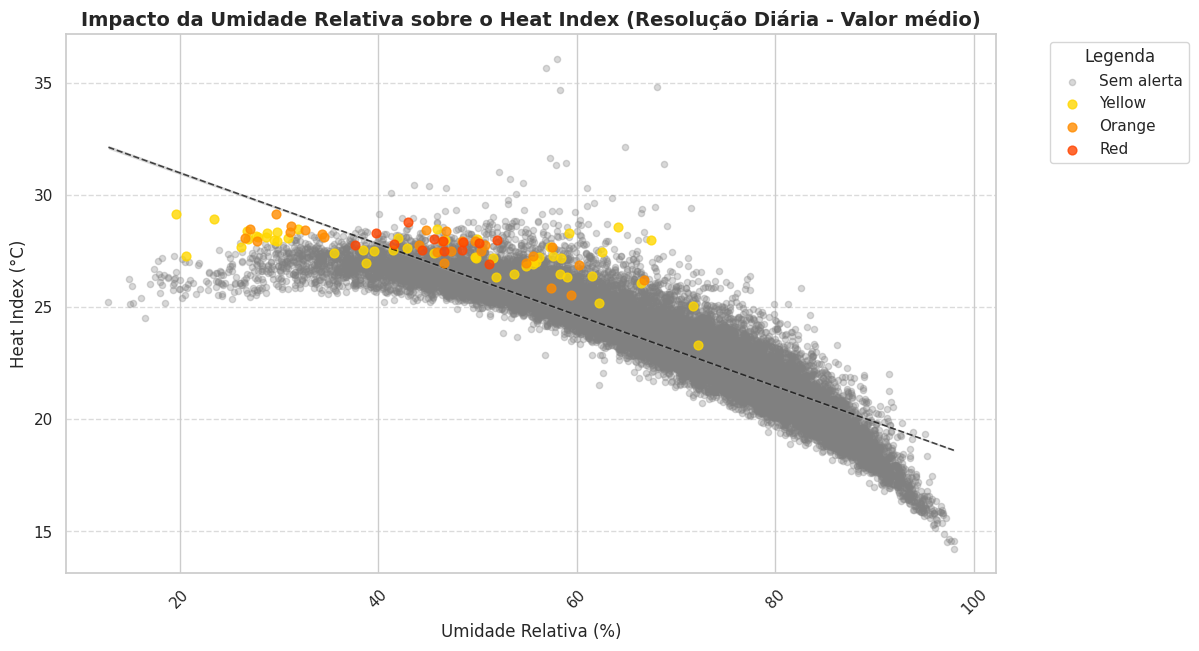

In [ ]:
# Agregar para resolução diária (média diária de heat index e umidade)
daily_data = all_MYs.groupby(all_MYs['timeset'].dt.date).agg({
    'heat_index': 'mean',  # Podemos trocar por 'max' se fizer mais sentido
    'humidity': 'mean',
    'heat_wave_alert': lambda x: x.dropna().unique()[0] if not x.dropna().empty else ''
}).reset_index()

# Separar DIAS com e sem alerta de onda de calor
df_alert = daily_data[daily_data['heat_wave_alert'] != '']
df_no_alert = daily_data[daily_data['heat_wave_alert'] == '']

# 🔎 Verificar o tamanho dos dataframes (em dias)
print(f'Dias com alerta: {len(df_alert)}')
print(f'Dias sem alerta: {len(df_no_alert)}')

plt.figure(figsize=(12, 7))

# Plotar os dias sem alerta (primeiro plano, menor transparência e tamanho menor)
plt.scatter(
    df_no_alert['humidity'],
    df_no_alert['heat_index'],
    color='gray',
    alpha=0.3,
    s=20,
    label='Sem alerta',
    zorder=1
)

# Plotar os dias com alerta (segundo plano, cores por nível de alerta)
plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'heat_index'],
    color='#FFD700',
    label='Yellow',
    s=40,
    alpha=0.8,
    zorder=2
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'heat_index'],
    color='#FF8C00',
    label='Orange',
    s=40,
    alpha=0.8,
    zorder=3
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'heat_index'],
    color='#FF4500',
    label='Red',
    s=40,
    alpha=0.8,
    zorder=4
)

# Adicionar linha de tendência para todos os dados
ax = sns.regplot(
    data=daily_data,
    x='humidity',
    y='heat_index',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--', 'linewidth': 1.2, 'alpha': 0.7}
)

# Forçar o zorder da linha de tendência manualmente
ax.get_children()[-1].set_zorder(5)

# Ajustar detalhes do gráfico
plt.title('Impacto da Umidade Relativa sobre o Heat Index (Resolução Diária - Valor médio)', fontsize=14, weight='bold')
plt.xlabel('Umidade Relativa (%)', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Dias com alerta: 90
Dias sem alerta: 22556


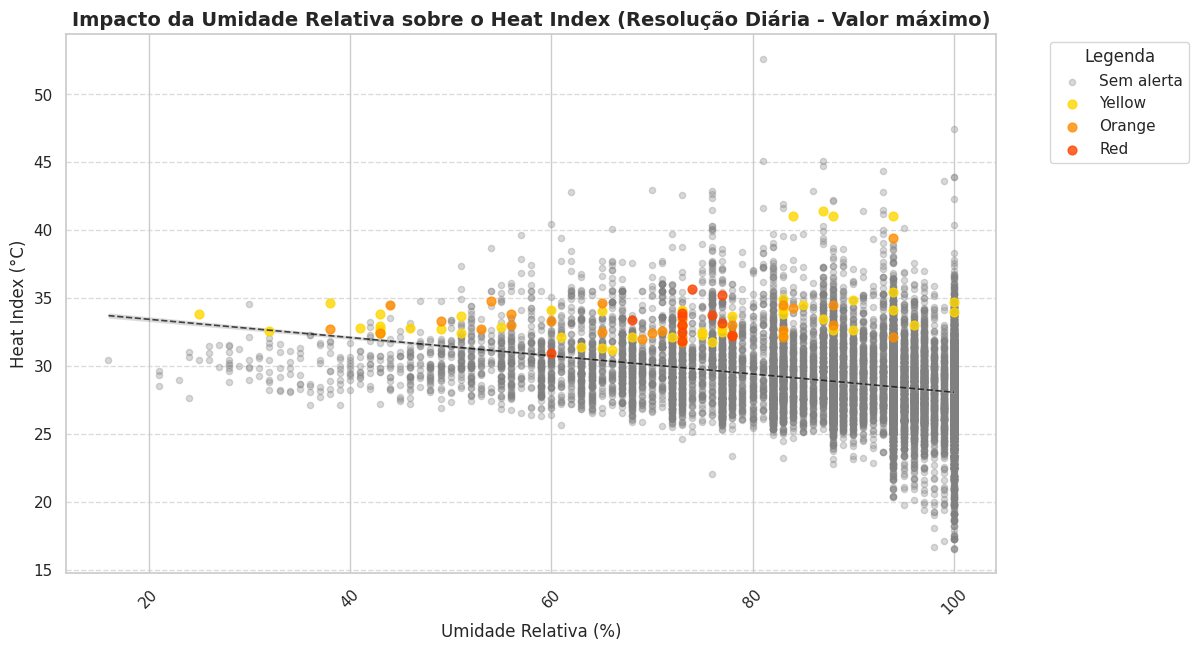

In [ ]:
# Agregar para resolução diária (máximo diário de heat index e umidade)
daily_data = all_MYs.groupby(all_MYs['timeset'].dt.date).agg({
    'heat_index': 'max',
    'humidity': 'max',
    'heat_wave_alert': lambda x: x.dropna().unique()[0] if not x.dropna().empty else ''
}).reset_index()

# Separar DIAS com e sem alerta de onda de calor
df_alert = daily_data[daily_data['heat_wave_alert'] != '']
df_no_alert = daily_data[daily_data['heat_wave_alert'] == '']

# 🔎 Verificar o tamanho dos dataframes (em dias)
print(f'Dias com alerta: {len(df_alert)}')
print(f'Dias sem alerta: {len(df_no_alert)}')

plt.figure(figsize=(12, 7))

# Plotar os dias sem alerta (primeiro plano, menor transparência e tamanho menor)
plt.scatter(
    df_no_alert['humidity'],
    df_no_alert['heat_index'],
    color='gray',
    alpha=0.3,
    s=20,
    label='Sem alerta',
    zorder=1
)

# Plotar os dias com alerta (segundo plano, cores por nível de alerta)
plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Yellow', 'heat_index'],
    color='#FFD700',
    label='Yellow',
    s=40,
    alpha=0.8,
    zorder=2
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Orange', 'heat_index'],
    color='#FF8C00',
    label='Orange',
    s=40,
    alpha=0.8,
    zorder=3
)

plt.scatter(
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'humidity'],
    df_alert.loc[df_alert['heat_wave_alert'] == 'Red', 'heat_index'],
    color='#FF4500',
    label='Red',
    s=40,
    alpha=0.8,
    zorder=4
)

# Adicionar linha de tendência para todos os dados
ax = sns.regplot(
    data=daily_data,
    x='humidity',
    y='heat_index',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--', 'linewidth': 1.2, 'alpha': 0.7}
)

# Forçar o zorder da linha de tendência manualmente
ax.get_children()[-1].set_zorder(5)

# Ajustar detalhes do gráfico
plt.title('Impacto da Umidade Relativa sobre o Heat Index (Resolução Diária - Valor máximo)', fontsize=14, weight='bold')
plt.xlabel('Umidade Relativa (%)', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


<ipython-input-73-387a39ad0746>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-73-387a39ad0746>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


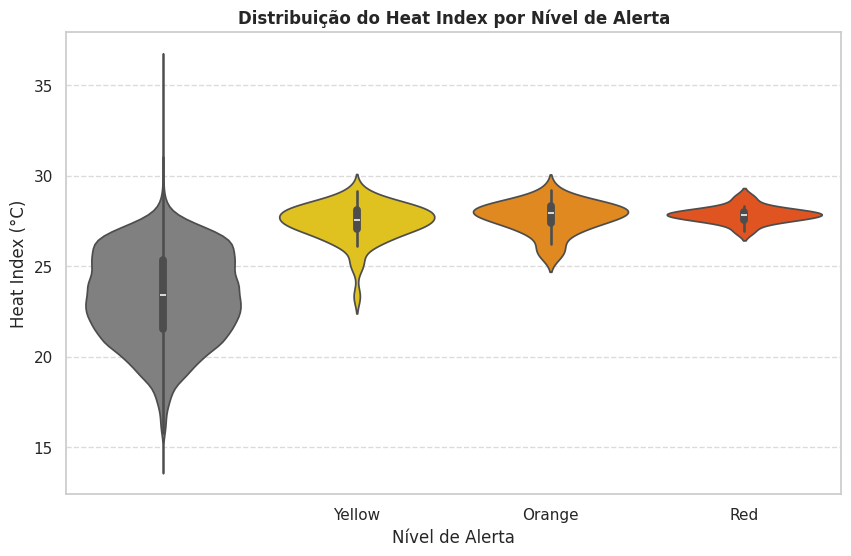

In [ ]:
plt.figure(figsize=(10, 6))

# Criar o gráfico de violino
sns.violinplot(
    data=daily_data,
    x='heat_wave_alert',
    y='heat_index',
    palette={'Yellow': '#FFD700', 'Orange': '#FF8C00', 'Red': '#FF4500', '': 'gray'},
    inner='box',  # Mostrar a posição da mediana e quartis
    scale='width'  # Ajustar a largura para representar a densidade
)

# Ajustar detalhes do gráfico
plt.title('Distribuição do Heat Index por Nível de Alerta', fontsize=12, weight='bold')
plt.xlabel('Nível de Alerta', fontsize=12)
plt.ylabel('Heat Index (°C)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
